# 4.1 word2vec 개선 
## 4.1.2 Embedding 계층 구현


In [9]:
import numpy as np
W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [11]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
            np.add.at(dW, self.idx, dout)
            
            return None

##  4.2.4 다중 분류애서의 이진 분류로

In [12]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, targer_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        dh = self.embed.backward(dtarget_W)
        return dh
    

In [13]:
W = np.array([[0,1,2], [3,4,5],[6,7,8], [9,10,11], [12,13,14],[15,16,17], [18,19,20]])
embed = Embedding(W)
idx = np.array([0,3,1])
target_W = embed.forward(idx)
h = np.array([[0,1,2], [3,4,5], [6,7,8]])
out = np.sum(target_W * h, axis=1) 

In [14]:
out

array([  5, 122,  86])

## 4.2.6 네거티브 샘플링의 기법

In [15]:
import numpy as np

np.random.choice(10)

5

In [16]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'I'

In [17]:
np.random.choice(words, size=5, replace=False)

array(['hello', 'goodbye', '.', 'say', 'I'], dtype='<U7')

In [18]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

In [19]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [22]:
import sys
sys.path.append('..')
from negative_sampling_layer import UnigramSampler

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 0]
 [2 0]
 [4 3]]


## 4.2.7 네거티브 샘플링 구현

In [ ]:
import sys
sys.path.append('..')
from negative_sampling_layer import SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.smapler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size+1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size+1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers : 
            self.params += layer.params
            self.gards += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtpye=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1+i].forward(h, negative_target)
            loss += self.loss_layers[1+i].forward(score, negative_label)
            
        return loss
        
        
        
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh
            

# 4.3 개선판 word2vec 학습
## 4.3.1 CBOW 모델 구현

In [ ]:
import sys
sys.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size , hideen_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
            
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        
        layers = self.in_layer + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.gards += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(cotexts[:, i])
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
            
        return None
    

## 4.3.2 CBOW 모델 학습 코드

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

| epoch 1 |  repeat 1 / 1859 | time 0[s] | loss 4.16
| epoch 1 |  repeat 21 / 1859 | time 5[s] | loss 4.16
| epoch 1 |  repeat 41 / 1859 | time 10[s] | loss 4.13
| epoch 1 |  repeat 61 / 1859 | time 14[s] | loss 4.01
| epoch 1 |  repeat 81 / 1859 | time 19[s] | loss 3.80
| epoch 1 |  repeat 101 / 1859 | time 24[s] | loss 3.54
| epoch 1 |  repeat 121 / 1859 | time 29[s] | loss 3.29
| epoch 1 |  repeat 141 / 1859 | time 34[s] | loss 3.10
| epoch 1 |  repeat 161 / 1859 | time 38[s] | loss 2.96
| epoch 1 |  repeat 181 / 1859 | time 43[s] | loss 2.86
| epoch 1 |  repeat 201 / 1859 | time 48[s] | loss 2.78
| epoch 1 |  repeat 221 / 1859 | time 52[s] | loss 2.72
| epoch 1 |  repeat 241 / 1859 | time 57[s] | loss 2.69
| epoch 1 |  repeat 261 / 1859 | time 62[s] | loss 2.66
| epoch 1 |  repeat 281 / 1859 | time 67[s] | loss 2.65
| epoch 1 |  repeat 301 / 1859 | time 72[s] | loss 2.62
| epoch 1 |  repeat 321 / 1859 | time 76[s] | loss 2.60
| epoch 1 |  repeat 341 / 1859 | time 81[s] | loss 2.59


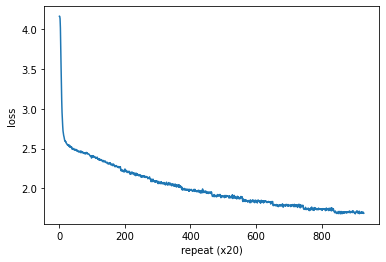

NameError: name 'word_vecs' is not defined

In [4]:
window_size = 5
hidden_size = 100
batch_size = 500
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    context, target = to_gpu(contexts), to_gpu(target)
    
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

if config.GPU:
    word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

## 4.3.3 CBOW 모델 평가

In [ ]:
import sys
sys.path.append('..')